In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, ZeroPadding2D, Flatten, Dense, Activation, Add, BatchNormalization, MaxPooling2D 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
#from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.applications.vgg16 import VGG16, preprocess_input

In [2]:
vgg = VGG16(input_shape=(512,512,3),  weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [3]:
x = Flatten()(vgg.output)
x = Dense(64, activation='relu')(x)
prediction = Dense(5, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0     

In [4]:
train_path = '../input/cassava-train/cassava_train/'
df = pd.read_csv('../input/cassava/train_data.csv')
#df.head()

df.label = df.label.astype('str')

In [5]:
size = 512
batch_size = 32
epochs = 25

In [6]:
traingen = ImageDataGenerator(rescale=1.0/255, validation_split=0.15,                                      
                                     rotation_range = 15,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.1,
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1)
validgen = ImageDataGenerator(rescale=1.0/255, validation_split=0.15)

In [7]:
train_gen = traingen.flow_from_dataframe(df, directory=train_path, 
                                       subset='training',
                                       x_col='image_id',
                                       y_col = "label",
                                       target_size = (size, size),
                                       batch_size = batch_size,
                                       shuffle=True,
                                       class_mode = "sparse")
valid_gen = validgen.flow_from_dataframe(df, directory=train_path, 
                                       subset='validation',
                                       x_col='image_id',
                                       y_col = "label",
                                       target_size = (size, size),
                                       batch_size = batch_size,
                                       shuffle=False,
                                       class_mode = "sparse")

Found 18006 validated image filenames belonging to 5 classes.
Found 3177 validated image filenames belonging to 5 classes.


In [8]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                               patience = 10, mode = 'min', verbose = 1,
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, 
                                      patience = 2, min_delta = 0.001, 
                                      mode = 'min', verbose = 1)

In [9]:
history = {}
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
              metrics=['accuracy'])
model_save = ModelCheckpoint('./vgg_transfer_cassava',
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
milestone = model.fit(train_gen,
          validation_data=valid_gen,
          epochs=epochs,
          steps_per_epoch=train_gen.n//train_gen.batch_size,
          validation_steps = valid_gen.n//valid_gen.batch_size,
          callbacks = [model_save, early_stop, reduce_lr]
          )
history['adam'] = milestone


Epoch 1/25
562/562 [==============================] - 1552s 3s/step - loss: 2.3093 - accuracy: 0.6055 - val_loss: 0.9153 - val_accuracy: 0.6499

Epoch 00001: val_loss improved from inf to 0.91526, saving model to ./vgg_transfer_cassava
Epoch 2/25
562/562 [==============================] - 1280s 2s/step - loss: 0.9035 - accuracy: 0.6554 - val_loss: 0.8693 - val_accuracy: 0.6607

Epoch 00002: val_loss improved from 0.91526 to 0.86930, saving model to ./vgg_transfer_cassava
Epoch 3/25
562/562 [==============================] - 1295s 2s/step - loss: 0.8682 - accuracy: 0.6654 - val_loss: 0.8847 - val_accuracy: 0.6705

Epoch 00003: val_loss did not improve from 0.86930
Epoch 4/25
562/562 [==============================] - 1262s 2s/step - loss: 0.8544 - accuracy: 0.6794 - val_loss: 0.8950 - val_accuracy: 0.6682

Epoch 00004: val_loss did not improve from 0.86930

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/25
562/562 [==============================

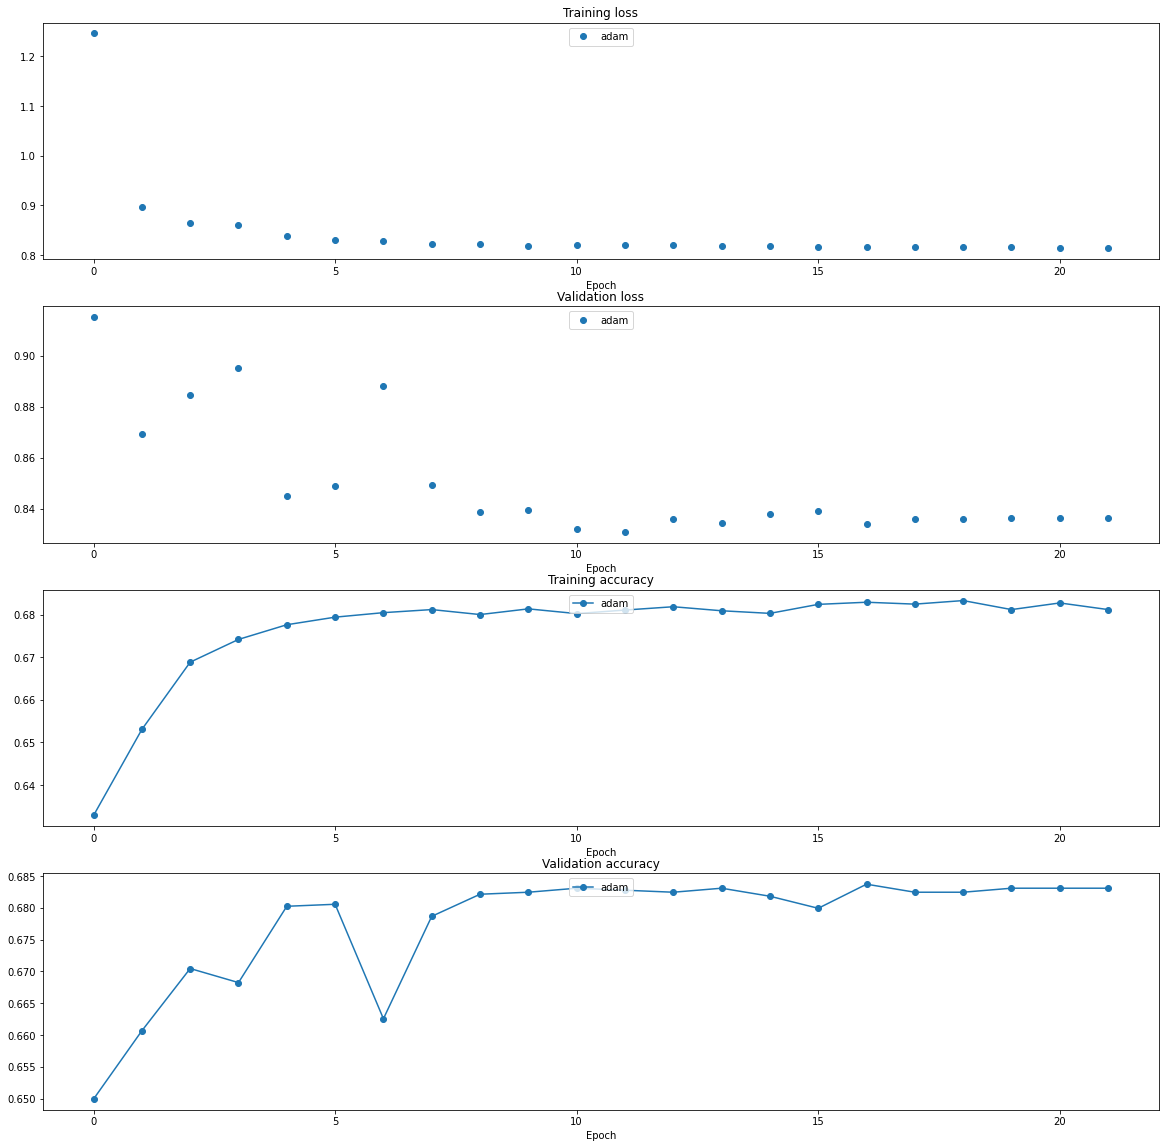

In [10]:
#Drawing
plt.subplot(4, 1, 1)
plt.title('Training loss')
plt.xlabel('Epoch')

plt.subplot(4, 1, 2)
plt.title('Validation loss')
plt.xlabel('Epoch')

plt.subplot(4, 1, 3)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(4, 1, 4)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, milestone in history.items():
    plt.subplot(4, 1, 1)
    plt.plot(milestone.history['loss'], 'o', label=update_rule)

    plt.subplot(4, 1, 2)
    plt.plot(milestone.history['val_loss'], 'o', label=update_rule)

    plt.subplot(4, 1, 3)
    plt.plot(milestone.history['accuracy'], '-o', label=update_rule)
    
    plt.subplot(4, 1, 4)
    plt.plot(milestone.history['val_accuracy'], '-o', label=update_rule)

for i in [1, 2, 3, 4]:
    plt.subplot(4, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(20, 20)
plt.show()